## Import Necessary Package

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!pip install optuna
!pip install polars
!pip install scikit-lego
!pip install skorch

In [ ]:
import os

import copy
import numpy as np
import pandas as pd
import polars as pl
import matplotlib
import matplotlib.pyplot as plt
import random
from itertools import cycle
from typing import Union, List, Optional
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import recall_score, roc_curve, auc
from sklego.meta import ZeroInflatedRegressor
import statsmodels.formula.api as smf
#import optuna
from torch import nn
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='SimHei')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import tensorflow as tf
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow import keras
from tensorflow.keras import layers

import torch
from torch import nn
from skorch import NeuralNetRegressor
import polars as pl

In [ ]:
import lightgbm as lgb
import xgboost as xgb

In [ ]:
import os
os.chdir("/content/drive/MyDrive/practicum_data")
from share_funcs import *

# Week 5: Zero-Inflate Regressor, Voting, Ensemble

## Training

### Data Reading

In [ ]:
# Read data
data = pd.read_csv("/content/drive/MyDrive/practicum_data/generated_data_50k.csv", index_col=0)
#data.dropna(axis=0, how='any', inplace=True)
data.head()

,g_m,g_T,g_r,g_q,g_sigma,g_eurocall
0,4.069980,1.259638,0.026336,0.019328,0.642441,0.013575
1,1.517319,0.206872,0.015114,0.021934,1.191723,0.082223
2,4.891844,1.879528,0.041911,0.014284,1.521444,0.433988
3,4.600171,1.877878,0.070135,0.045644,0.961598,0.144128
4,4.540752,1.348743,0.057329,0.040501,0.378899,0.000078


In [ ]:
#lgb xgb
xgb_data = copy.deepcopy(data)
lgb_data = copy.deepcopy(data)

In [ ]:
# train/test data set for XGB
X_xgb = xgb_data.drop(['g_eurocall'], axis=1)
y_xgb = xgb_data['g_eurocall']
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.3, random_state=10)

# train/test data set for LGBM
X_lgb = lgb_data.drop(['g_eurocall'], axis=1)
y_lgb = lgb_data['g_eurocall']
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_lgb, y_lgb, test_size=0.3, random_state=10)

### Train Classifier for Zero-Inflated Regressor

#### Train best xgboost Classifier

In [ ]:
y_xgb_classify = (y_xgb > 0).astype(np.int64)
y_lgb_classify = (y_lgb > 0).astype(np.int64)

y_train_xgb_classify = y_xgb_classify[y_train_xgb.index]
y_test_xgb_classify = y_xgb_classify[y_test_xgb.index]


y_train_lgb_classify = y_lgb_classify[y_train_lgb.index]
y_test_lgb_classify = y_lgb_classify[y_test_lgb.index]

In [ ]:
y_xgb_classify.value_counts()

1    44158
0     5842
Name: g_eurocall, dtype: int64

In [ ]:
param_clf_xgb={'n_estimators': [200, 400, 800], 'subsample': [0.6, 0.8], 'colsample_bytree': [0.8, 1],'lambda_l2': [0, 1], 'min_child_weight': [1, 5, 10]}
grid_xgb_clf = trainmodel(xgb.XGBClassifier, X_train_xgb, y_train_xgb_classify, param_clf_xgb)

Best: -0.004286 using {'colsample_bytree': 1, 'lambda_l2': 0, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.6}


In [ ]:
tmp_xgb_clf1= train_best_clf(xgb.XGBClassifier, X_train_xgb, y_train_xgb_classify,X_test_xgb,y_test_xgb_classify,"xgb classifier", **{'colsample_bytree': 1, 'lambda_l2': 0, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.6})

Current Best xgb classifier Performance:
XGBClassifier(lambda_l2=0, n_estimators=800, subsample=0.6)
Train Set rmse:  0.0
xgb classifier rmse:  0.0621825270205921 mae: 0.0038666666666666667
Accuracy 0.9961333333333333


In [ ]:
tmp_xgb_clf2 = train_best_clf(xgb.XGBClassifier, X_train_xgb, y_train_xgb_classify,X_test_xgb,y_test_xgb_classify,"xgb classifier", max_depth=5, reg_alpha=0.5, lambda_l2=1, eta=0.05, n_estimators=400, colsample_bytree=0.8)

Current Best xgb classifier Performance:
XGBClassifier(colsample_bytree=0.8, eta=0.05, lambda_l2=1, max_depth=5,
              n_estimators=400, reg_alpha=0.5)
Train Set rmse:  0.0
xgb classifier rmse:  0.07745966692414834 mae: 0.006
Accuracy 0.994


#### Train best lightgbm Classifier

In [ ]:
param_clf_lgb = {
      'num_leaves': [17, 31, 63],
      'max_bins': [31 ,63, 127],
      'min_data_in_leaf': [30, 60, 90],
      'lambda_l1': [0, 0.1, 0.5],
      'lambda_l2': [0, 1],
      'num_estimators': [200, 400]
      }

grid_lgb_clf = trainmodel(lgb.LGBMClassifier, X_train_lgb, y_train_lgb_classify, param_clf_lgb)

Best: -0.005371 using {'lambda_l1': 0.5, 'lambda_l2': 1, 'max_bins': 31, 'min_data_in_leaf': 90, 'num_estimators': 200, 'num_leaves': 31}


In [ ]:
tmp_lgb_clf1 = train_best_clf(lgb.LGBMClassifier, X_train_lgb, y_train_lgb_classify,X_test_lgb,y_test_lgb_classify,"lgb classifier", **{'lambda_l1': 0.5, 'lambda_l2': 1, 'max_bins': 31, 'min_data_in_leaf': 90, 'num_estimators': 200, 'num_leaves': 31})

Current Best lgb classifier Performance:
LGBMClassifier(lambda_l1=0.5, lambda_l2=1, max_bins=31, min_data_in_leaf=90,
               num_estimators=200)
Train Set rmse:  0.016035674514745465
lgb classifier rmse:  0.08 mae: 0.0064
Accuracy 0.9936


LGBMClassifier(lambda_l1=0.5, lambda_l2=1, max_bins=31, min_data_in_leaf=90,
               num_estimators=200)

In [ ]:
tmp_lgb_clf2 = train_best_clf(lgb.LGBMClassifier, X_train_lgb, y_train_lgb_classify,X_test_lgb,y_test_lgb_classify,"lgb classifier", **{'lambda_l1': 0, 'lambda_l2': 1, 'max_bins': 31, 'min_data_in_leaf': 30, 'num_leaves': 31,'n_estimators':400})

Current Best lgb classifier Performance:
LGBMClassifier(lambda_l1=0, lambda_l2=1, max_bins=31, min_data_in_leaf=30,
               n_estimators=400)
Train Set rmse:  0.0
lgb classifier rmse:  0.07659416862050705 mae: 0.005866666666666667
Accuracy 0.9941333333333333


LGBMClassifier(lambda_l1=0, lambda_l2=1, max_bins=31, min_data_in_leaf=30,
               n_estimators=400)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
train_best_clf(RandomForestClassifier, X_train_lgb, y_train_lgb_classify,X_test_lgb,y_test_lgb_classify, 'rf classifier', max_features=5, n_estimators=400)

Current Best rf classifier Performance:
RandomForestClassifier(max_features=5, n_estimators=400)
Train Set rmse:  0.0
rf classifier rmse:  0.09486832980505137 mae: 0.009
Accuracy 0.991


RandomForestClassifier(max_features=5, n_estimators=400)

#### Train Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier,  StackingRegressor, StackingClassifier
named_clf_estimators = [("lgb_clf1", lgb.LGBMClassifier(**{'lambda_l1': 0.5, 'lambda_l2': 1, 'max_bins': 31, 'min_data_in_leaf': 90, 'num_estimators': 200, 'num_leaves': 31})),
                        #("lgb_clf2", lgb.LGBMClassifier(**{'lambda_l1': 0, 'lambda_l2': 1, 'max_bins': 31, 'min_data_in_leaf': 30, 'num_leaves': 31,'n_estimators':400})),
                        ("xgb_clf1", xgb.XGBClassifier(**{'colsample_bytree': 1, 'lambda_l2': 0, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.6})),
                        #("xgb_clf2", xgb.XGBClassifier(max_depth=5, reg_alpha=0.5, lambda_l2=1, eta=0.05, n_estimators=400, colsample_bytree=0.8))
                        ]
#voting_clf = VotingClassifier(named_clf_estimators)
#train_best_clf(VotingClassifier, X_train_xgb, y_train_xgb_classify,X_test_xgb,y_test_xgb_classify,"voting classifier", estimators=named_clf_estimators, voting='soft')
train_best_clf(StackingClassifier, X_train_xgb, y_train_xgb_classify,X_test_xgb,y_test_xgb_classify, "stacking classifier", estimators=named_clf_estimators, cv= 5, passthrough = True)

Current Best stacking classifier Performance:
StackingClassifier(cv=5,
                   estimators=[('lgb_clf1',
                                LGBMClassifier(lambda_l1=0.5, lambda_l2=1,
                                               max_bins=31, min_data_in_leaf=90,
                                               num_estimators=200)),
                               ('xgb_clf1',
                                XGBClassifier(lambda_l2=0, n_estimators=800,
                                              subsample=0.6))],
                   passthrough=True)
Train Set rmse:  0.005345224838248488
stacking classifier rmse:  0.06429100507328636 mae: 0.0041333333333333335
Accuracy 0.9958666666666667


StackingClassifier(cv=5,
                   estimators=[('lgb_clf1',
                                LGBMClassifier(lambda_l1=0.5, lambda_l2=1,
                                               max_bins=31, min_data_in_leaf=90,
                                               num_estimators=200)),
                               ('xgb_clf1',
                                XGBClassifier(lambda_l2=0, n_estimators=800,
                                              subsample=0.6))],
                   passthrough=True)

### ZeroInflatedRegressor For XGBoost & LightGBM

#### XGBoost(Two best Models)

In [ ]:
xgb_both = ZeroInflatedRegressor
xgb_both = train_best_reg(xgb_both, X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb, "xgb_combine",
                          classifier=xgb.XGBClassifier(max_depth=5, reg_alpha=0.5, lambda_l2=1, eta=0.05, n_estimators=400, colsample_bytree=1),
                          regressor=xgb.XGBRegressor(max_depth=5,lambda_l2=1,eta=0.05, reg_alpha=0, n_estimators=1600, colsample_bytree=0.8))

[17:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Current Best xgb_combine Performance:
ZeroInflatedRegressor(classifier=XGBClassifier(eta=0.05, lambda_l2=1,
                                               max_depth=5, n_estimators=400,
                                               reg_alpha=0.5),
                      regressor=XGBRegressor(colsample_bytree=0.8, eta=0.05,
                                             lambda_l2=1, max_depth=5,
                                             n_estimators=1600))
Train Set rmse:  0.003
xgb_combine rmse:  0.00536 mae: 0.00376
xgb_combine r2:  0.9995


In [ ]:
xgb_both_predict = xgb_both.predict(X_test_lgb)
xgb_both_predict = pd.Series(np.where(xgb_both_predict < 0, 0, xgb_both_predict), name='predict_xgb_both2', index=X_test_xgb.index)
err_xgb = pd.concat([X_test_lgb, y_test_lgb,xgb_both_predict], axis=1)
err_xgb['err_xgb'] = err_xgb['g_eurocall'] - err_xgb['predict_xgb_both2']
(err_xgb['err_xgb'].abs()/err_xgb['g_eurocall']).quantile([0,0.25,0.5,0.75,0.90,0.95,0.99,1])
#err_lgb2['lgb_abs_per_err'] = (err_lgb2['err_lgb2'].abs()/err_lgb2['g_eurocall'])
#err_lgb2[err_lgb2['g_eurocall'] != 0].sort_values('lgb_abs_per_err', ascending=False)

NameError: ignored

In [ ]:
xgb_both2 = train_best_reg(ZeroInflatedRegressor, X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb, "xgb_combine",
                          classifier=xgb.XGBClassifier(**{'colsample_bytree': 1, 'lambda_l2': 0, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.6}),
                          regressor=xgb.XGBRegressor(max_depth=5,lambda_l2=1,eta=0.05, reg_alpha=0, n_estimators=1600, colsample_bytree=0.8))

[17:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Current Best xgb_combine Performance:
ZeroInflatedRegressor(classifier=XGBClassifier(lambda_l2=0, n_estimators=800,
                                               subsample=0.6),
                      regressor=XGBRegressor(colsample_bytree=0.8, eta=0.05,
                                             lambda_l2=1, max_depth=5,
                                             n_estimators=1600))
Train Set rmse:  0.003
xgb_combine rmse:  0.00535 mae: 0.00375
xgb_combine r2:  0.9995


#### LightGBM(Two Best Models)

In [ ]:
lgb_both = train_best_reg(ZeroInflatedRegressor, X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb, "lgb_combine",
                          classifier=lgb.LGBMClassifier(**{'lambda_l1': 0, 'lambda_l2': 1, 'max_bins': 31, 'min_data_in_leaf': 30, 'num_leaves': 31,'n_estimators':400}),
                          regressor=lgb.LGBMRegressor(**{'lambda_l1': 0, 'lambda_l2': 1, 'max_bins': 63, 'min_data_in_leaf': 60, 'num_leaves': 62,'n_estimators':400}))

Current Best lgb_combine Performance:
ZeroInflatedRegressor(classifier=LGBMClassifier(lambda_l1=0, lambda_l2=1,
                                                max_bins=31,
                                                min_data_in_leaf=30,
                                                n_estimators=400),
                      regressor=LGBMRegressor(lambda_l1=0, lambda_l2=1,
                                              max_bins=63, min_data_in_leaf=60,
                                              n_estimators=400, num_leaves=62))
Train Set rmse:  0.00401
lgb_combine rmse:  0.00583 mae: 0.004
lgb_combine r2:  0.99941


In [ ]:
lgb_both2 = train_best_reg(ZeroInflatedRegressor, X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb, "lgb_combine",
                          classifier=lgb.LGBMClassifier(**{'lambda_l1': 0.5, 'lambda_l2': 1, 'max_bins': 31, 'min_data_in_leaf': 90, 'num_estimators': 200, 'num_leaves': 31}),
                          regressor=lgb.LGBMRegressor(**{'lambda_l1': 0, 'lambda_l2': 1, 'max_bins': 63, 'min_data_in_leaf': 60, 'num_leaves': 62,'n_estimators':400}))


Current Best lgb_combine Performance:
ZeroInflatedRegressor(classifier=LGBMClassifier(lambda_l1=0.5, lambda_l2=1,
                                                max_bins=31,
                                                min_data_in_leaf=90,
                                                num_estimators=200),
                      regressor=LGBMRegressor(lambda_l1=0, lambda_l2=1,
                                              max_bins=63, min_data_in_leaf=60,
                                              n_estimators=400, num_leaves=62))
Train Set rmse:  0.00402
lgb_combine rmse:  0.00581 mae: 0.00396
lgb_combine r2:  0.99941


In [ ]:
lgb_both2_predict = lgb_both2.predict(X_test_lgb)
lgb_both2_predict = pd.Series(np.where(lgb_both2_predict < 0, 0, lgb_both2_predict), name='predict_lgb_both2', index=X_test_lgb.index)
err_lgb2 = pd.concat([X_test_lgb, y_test_lgb,lgb_both2_predict], axis=1)
err_lgb2['err_lgb2'] = err_lgb2['g_eurocall'] - err_lgb2['predict_lgb_both2']
(err_lgb2['err_lgb2'].abs()/err_lgb2['g_eurocall']).quantile([0,0.25,0.5,0.75,0.90,0.95,0.99,1])
#err_lgb2['lgb_abs_per_err'] = (err_lgb2['err_lgb2'].abs()/err_lgb2['g_eurocall'])
#err_lgb2[err_lgb2['g_eurocall'] != 0].sort_values('lgb_abs_per_err', ascending=False)

0.00    0.000005
0.25    0.007601
0.50    0.020506
0.75    0.064791
0.90    0.353224
0.95    1.000000
0.99    3.296061
1.00         NaN
dtype: float64

### Stacking Zero-Inflated Regressor(Over 2 XGB & 2LGB Models)

In [ ]:
print(X_xgb.mean(axis=0).values, X_xgb.std(axis=0).values)

[2.59564865 1.00528802 0.03986204 0.02523768 1.06051767] [1.38237971 0.57541136 0.02325452 0.01445998 0.55268058]


#### ANN model

In [ ]:
class PricingNetwork2(nn.Module):
  def __init__(self, mean=X_train_xgb.mean(axis=0).values.astype(np.float32), std=X_train_xgb.std(axis=0).values.astype(np.float32), neurons=64, x_features=5):
  #def __init__(self, neurons=64, x_features=5):
    super(PricingNetwork2,self).__init__()
    self.mean = mean
    self.std = std
    self.bottleneck = nn.ModuleList([nn.Linear(x_features, neurons), nn.LeakyReLU()] + [nn.Linear(neurons, neurons), nn.LeakyReLU()] * 4)

    self.final_layer = nn.Linear(neurons, 1)

  def forward(self, X, **kwargs):
    #X = (X - np.array([2.59564865,1.00528802,0.03986204,0.02523768,1.06051767], dtype=np.float32)) / np.array([1.38237971, 0.57541136, 0.02325452, 0.01445998, 0.55268058],dtype=np.float32)
    #(X - X.mean(axis=0))/X.std(axis=0)
    X = (X - self.mean) / self.std
    for layer in self.bottleneck:
      X = layer(X)
    X  = self.final_layer(X)
    return X

In [ ]:
net = NeuralNetRegressor(
  PricingNetwork2,
  optimizer=torch.optim.Adam,
  max_epochs=50,
  batch_size=512,
  criterion=nn.MSELoss(),
  lr=0.01,
  # Shuffle training data on each epoch
  iterator_train__shuffle=True,
)



In [ ]:
X_train_ann = X_train_xgb.values.astype(np.float32)
y_train_ann = y_train_xgb.values.reshape(-1,1).astype(np.float32)

In [ ]:
X_test_ann = X_test_xgb.values.astype(np.float32)
y_test_ann = y_test_xgb.values.reshape(-1,1).astype(np.float32)

In [ ]:
net.fit(X_train_ann,y_train_ann)

In [ ]:
 (y_test_xgb - pd.Series((net.predict(X_test_xgb.values.astype(np.float32))).flatten(), index=X_test_xgb.index)).abs().quantile([0,0.25,0.5,0.75,0.85,0.9,1])

0.00    0.000002
0.25    0.012075
0.50    0.026011
0.75    0.047350
0.85    0.061046
0.90    0.071835
1.00    0.345051
dtype: float64

In [ ]:
class PricingDataset(torch.utils.data.Dataset):
  def __init__(self, data: pd.DataFrame, y:str):
    """Initializes instance of class StudentsPerformanceDataset.
    Args:
        csv_file (str): Path to the csv file with the students data.
    """
    self.df = data

    # Grouping variable names
    self.target = y

    # Save target and predictors
    self.X = self.df.drop(self.target, axis=1).values
    self.y = self.df[self.target].values.reshape(-1,1)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
    #if isinstance(idx, torch.Tensor):
      #idx = idx.tolist()

    return self.X[idx], self.y[idx]


In [ ]:
data.head()

,g_m,g_T,g_r,g_q,g_sigma,g_eurocall
0,4.069980,1.259638,0.026336,0.019328,0.642441,0.013575
1,1.517319,0.206872,0.015114,0.021934,1.191723,0.082223
2,4.891844,1.879528,0.041911,0.014284,1.521444,0.433988
3,4.600171,1.877878,0.070135,0.045644,0.961598,0.144128
4,4.540752,1.348743,0.057329,0.040501,0.378899,0.000078


In [ ]:
X_train_ann.astype(np.float32)

tensor([[4.8626e+00, 1.9853e+00, 3.9631e-03, 4.2865e-03, 9.4196e-01],
        [3.9995e+00, 9.3722e-01, 2.6076e-02, 4.1280e-02, 1.4888e+00],
        [2.8142e+00, 4.3326e-02, 3.8961e-02, 1.9464e-02, 7.8767e-01],
        ...,
        [4.6661e+00, 1.1260e-01, 2.7792e-02, 7.6033e-03, 1.5531e+00],
        [3.2872e+00, 1.1243e+00, 3.6604e-02, 1.6005e-02, 1.8400e+00],
        [2.9385e-01, 1.7917e+00, 8.7882e-03, 3.6101e-02, 6.0827e-01]],
       dtype=torch.float64)

In [ ]:
y_test_ann

array([[0.29882562],
       [0.3061037 ],
       [0.24703854],
       ...,
       [0.25240323],
       [0.11400653],
       [0.        ]], dtype=float32)

In [ ]:
def train_best_reg(model, X_train: pd.DataFrame, y_train: Union[pd.DataFrame, pd.Series], X_test: pd.DataFrame,
              y_test:Union[pd.DataFrame, pd.Series], name: str="Model", **kwargs):
  model_instance = model(**kwargs)
  model_instance.fit(X_train, y_train)
  print(f"Current Best {name} Performance:")
  print(model_instance)
  # y_test_predict = err_check(model_instance.predict(X_test))
  y_test_predict = model_instance.predict(X_test).reshape()
  rmse = np.around(np.sqrt(mean_squared_error(y_test, y_test_predict)), decimals=5)
  mae = np.around(mean_absolute_error(y_test, y_test_predict), decimals=5)
  r2 = np.around(r2_score(y_test, y_test_predict), decimals=5)
  print("Train Set rmse: ", np.around(np.sqrt(mean_squared_error(y_train, model_instance.predict(X_train))), decimals=5))
  print(f"{name} rmse: ", rmse, "mae:", mae)
  print(f"{name} r2: ", r2)
  return model_instance

In [ ]:
stack_estimators=[
     ('lgb_both1', lgb_both),
     ('lgb_both2', lgb_both2),
     ('xgb_both1', xgb_both),
     ('xgb_both2', xgb_both2),
 ]
stack = StackingRegressor(estimators=stack_estimators, cv= 5, passthrough = True)
 # stack.fit(X_train_lgb, y_train_lgb)
stack_xgb_lgb = train_best_reg(StackingRegressor, X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb, "stack", estimators=stack_estimators, cv= 5, passthrough = True)

[22:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
xgb_lgb1 = train_best_reg(ZeroInflatedRegressor, X_train_ann, y_train_ann, X_test_ann, y_test_ann, "stack_regressor", classifier=xgb.XGBClassifier(**{'colsample_bytree': 1, 'lambda_l2': 0, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.6}),
                               regressor=lgb.LGBMRegressor(**{'lambda_l1': 0, 'lambda_l2': 1, 'max_bins': 63, 'min_data_in_leaf': 60, 'num_leaves': 62,'n_estimators':400}))
lgb_trained=xgb_lgb1.regressor

Current Best stack_regressor Performance:
ZeroInflatedRegressor(classifier=XGBClassifier(lambda_l2=0, n_estimators=800,
                                               subsample=0.6),
                      regressor=LGBMRegressor(lambda_l1=0, lambda_l2=1,
                                              max_bins=63, min_data_in_leaf=60,
                                              n_estimators=400, num_leaves=62))
Train Set rmse:  0.00401
stack_regressor rmse:  0.00583 mae: 0.004
stack_regressor r2:  0.99941


In [ ]:
xgb_lgb2 = train_best_reg(ZeroInflatedRegressor, X_train_ann, y_train_ann, X_test_ann, y_test_ann, "stack_regressor", classifier=xgb.XGBClassifier(**{'colsample_bytree': 1, 'lambda_l2': 0, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.6}),
                               regressor=xgb.XGBRegressor(max_depth=5,lambda_l2=1,eta=0.05, reg_alpha=0, n_estimators=1600, colsample_bytree=0.8))
xgb_trained=xgb_lgb2.regressor

[06:15:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Current Best stack_regressor Performance:
ZeroInflatedRegressor(classifier=XGBClassifier(lambda_l2=0, n_estimators=800,
                                               subsample=0.6),
                      regressor=XGBRegressor(colsample_bytree=0.8, eta=0.05,
                                             lambda_l2=1, max_depth=5,
                                             n_estimators=1600))
Train Set rmse:  0.003
stack_regressor rmse:  0.00535 mae: 0.00375
stack_regressor r2:  0.9995


In [ ]:
stack_estimators=[
     ('lgb_', lgb_trained),
     ('xgb_', xgb_trained),
     ('ann_', net)
     ]
stacked2 = ZeroInflatedRegressor(classifier=xgb.XGBClassifier(**{'colsample_bytree': 1, 'lambda_l2': 0, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.6}),
                      regressor=StackingRegressor(estimators=stack_estimators,cv="prefit", final_estimator=mylasso(Lasso), passthrough = True))
stacked2.fit(X_test_ann, y_test_ann)

[06:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


ValueError: ignored

In [ ]:
y_train_ann.ndim

2

In [ ]:
from sklearn.linear_model import Lasso
stack_estimators=[
     ('lgb_', lgb.LGBMRegressor(**{'lambda_l1': 0, 'lambda_l2': 1, 'max_bins': 63, 'min_data_in_leaf': 60, 'num_leaves': 62,'n_estimators':400})),
     ('xgb_', xgb.XGBRegressor(max_depth=5,lambda_l2=1,eta=0.05, reg_alpha=0, n_estimators=1600, colsample_bytree=0.8)),
     #('ann_', net)
     ]
stack_xgb_lgb2 = train_best_reg(ZeroInflatedRegressor, X_train_ann, y_train_ann, X_test_ann, y_test_ann, "stack_regressor", classifier=xgb.XGBClassifier(**{'colsample_bytree': 1, 'lambda_l2': 0, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.6}),
                               regressor=StackingRegressor(estimators=stack_estimators, cv="prefit", passthrough = True))

KeyboardInterrupt: ignored

In [ ]:
stack_estimators=[
     ('lgb_', lgb.LGBMRegressor(**{'lambda_l1': 0, 'lambda_l2': 1, 'max_bins': 63, 'min_data_in_leaf': 60, 'num_leaves': 62,'n_estimators':400})),
     ('xgb_', xgb.XGBRegressor(max_depth=5,lambda_l2=1,eta=0.05, reg_alpha=0, n_estimators=1600, colsample_bytree=0.8)),
     ('rf_', RandomForestRegressor(max_features=3, n_estimators=200)),
     #('ann_', PricingNetworkRegressor(neurons=64))
 ]

stack_xgb_lgb3 = train_best_reg(ZeroInflatedRegressor, X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb, "stack_regressor",
                               classifier= xgb.XGBClassifier(**{'colsample_bytree': 1, 'lambda_l2': 0, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.6}),
                               regressor= StackingRegressor(estimators=stack_estimators,cv=5, passthrough = True))

[17:55:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:56:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:57:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:57:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:58:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Current Best stack_regressor Performance:
ZeroInflatedRegressor(classifier=XGBClassifier(lambda_l2=0, n_estimators=800,
                                               subsample=0.6),
                      regressor=StackingRegressor(cv=5,

In [ ]:
train_best_reg(StackingRegressor, X_train_lgb, y_train_lgb, X_test_lgb, y_test_lgb, "stack", estimators=stack_estimators, cv= 5, passthrough = True)

## Error Analysis

### Classifier Error Analysis

In [ ]:
# Total 58 incorrect result
best_xgb_clf_err = pl.from_pandas(pd.concat([error_table(tmp_xgb_clf1, X_test_xgb, y_test_xgb_classify, "xgb_clf"), y_test_xgb.rename("exact_call")], axis=1))

pd.DataFrame(confusion_matrix(best_xgb_clf_err[:,'g_eurocall'].to_series().to_pandas(), best_xgb_clf_err[:,'predict_xgb_clf'].to_series().to_pandas()),
            columns=['0', '1'], index=['0', '1'])


,0,1
0,1725,32
1,26,13217


In [ ]:
best_xgb_clf_err.filter(pl.col("error_xgb_clf") != 0).sort('exact_call', reverse=True)

g_m,g_T,g_r,g_q,g_sigma,g_eurocall,predict_xgb_clf,error_xgb_clf,exact_call
f64,f64,f64,f64,f64,i64,i64,i64,f64
2.172262,0.091142,0.053482,0.023329,0.73389,1,0,1,0.00002
3.899344,1.190099,0.064795,0.012721,0.323797,1,0,1,0.000019
1.776607,1.223813,0.042277,0.040011,0.151764,1,0,1,0.000018
4.233817,1.712876,0.03402,0.003802,0.285862,1,0,1,0.000018
1.430335,1.29529,0.044535,0.004107,0.082606,1,0,1,0.000017
4.491121,0.187953,0.005864,0.041673,0.922646,1,0,1,0.000016
1.767079,1.349842,0.005286,0.003996,0.140817,1,0,1,0.000014
1.581526,0.459784,0.03619,0.045794,0.200382,1,0,1,0.000014
3.632279,1.046603,0.07204,0.031637,0.327189,1,0,1,0.000014


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7417c1b50>]],
      dtype=object)

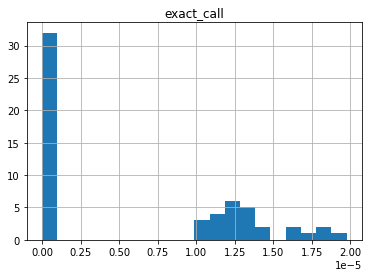

In [ ]:
best_xgb_clf_err.filter(pl.col("error_xgb_clf") != 0)[:,'exact_call'].to_pandas().hist(bins=20)#.filter(pl.col("g_m" > 2.5))

In [ ]:
#Always update when try to add more models!!!!
#models = [xgb_both,xgb_both2,lgb_both, lgb_both2, stack_xgb_lgb, stack_xgb_lgb2]
models = [xgb_both,xgb_both2,lgb_both, lgb_both2, ann_model ,stack_xgb_lgb2, stack_xgb_lgb3]
#model_names = ['xgb_both', 'xgb_both2','lgb_both','lgb_both2', 'stack_xgb_lgb', 'stack_xgb_lgb2']
model_names = ['xgb_both', 'xgb_both2','lgb_both','lgb_both2', 'ann_model' ,'stack_xgb_lgb2', 'stack_xgb_lgb3',]

In [ ]:
err_table = error_table(models, X_test_xgb, y_test_xgb, model_names)
err_table.head()
#err_table.to_csv("/content/drive/MyDrive/practicum_data/ensemble_res_50k.csv")

469/469 [==============================] - 1s 2ms/step


,g_m,g_T,g_r,g_q,g_sigma,g_eurocall,predict_xgb_both,predict_xgb_both2,predict_lgb_both,predict_lgb_both2,predict_ann_model,predict_stack_xgb_lgb2,predict_stack_xgb_lgb3,error_xgb_both,error_xgb_both2,error_lgb_both,error_lgb_both2,error_ann_model,error_stack_xgb_lgb2,error_stack_xgb_lgb3
27632,3.609691,1.009831,0.035884,0.023683,1.595773,0.298826,0.294283,0.294283,0.299739,0.294885,0.298615,0.296768,0.296240,0.004543,0.004543,-0.000913,0.003941,0.000210,0.002057,0.002586
36119,4.419299,1.748073,0.064597,0.011920,1.270371,0.306104,0.295589,0.295589,0.302087,0.300691,0.301880,0.299075,0.299914,0.010514,0.010514,0.004017,0.005412,0.004223,0.007029,0.006190
4796,4.574501,1.080643,0.039175,0.018941,1.517189,0.247039,0.247852,0.247852,0.249227,0.243709,0.245477,0.248295,0.249781,-0.000814,-0.000814,-0.002189,0.003330,0.001562,-0.001256,-0.002743
3648,4.526990,1.990202,0.034237,0.048131,1.022393,0.175483,0.176730,0.176730,0.180237,0.185058,0.175681,0.177684,0.178481,-0.001248,-0.001248,-0.004754,-0.009575,-0.000198,-0.002202,-0.002999
24501,4.257135,0.446676,0.078915,0.028430,1.773277,0.118269,0.123781,0.123781,0.125934,0.127325,0.111357,0.124681,0.125181,-0.005512,-0.005512,-0.007666,-0.009057,0.006912,-0.006413,-0.006913


In [ ]:
err_table = pl.from_pandas(err_table) if 'err_table' in globals() else pl.read_csv("/content/drive/MyDrive/practicum_data/ensemble_res_50k.csv")
err_table.head()

g_m,g_T,g_r,g_q,g_sigma,g_eurocall,predict_xgb_both,predict_xgb_both2,predict_lgb_both,predict_lgb_both2,predict_ann_model,predict_stack_xgb_lgb2,predict_stack_xgb_lgb3,error_xgb_both,error_xgb_both2,error_lgb_both,error_lgb_both2,error_ann_model,error_stack_xgb_lgb2,error_stack_xgb_lgb3
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64
3.609691,1.009831,0.035884,0.023683,1.595773,0.298826,0.294283,0.294283,0.299739,0.294885,0.298615,0.296768,0.29624,0.004543,0.004543,-0.000913,0.003941,0.00021,0.002057,0.002586
4.419299,1.748073,0.064597,0.01192,1.270371,0.306104,0.295589,0.295589,0.302087,0.300691,0.30188,0.299075,0.299914,0.010514,0.010514,0.004017,0.005412,0.004223,0.007029,0.00619
4.574501,1.080643,0.039175,0.018941,1.517189,0.247039,0.247852,0.247852,0.249227,0.243709,0.245477,0.248295,0.249781,-0.000814,-0.000814,-0.002189,0.00333,0.001562,-0.001256,-0.002743
4.52699,1.990202,0.034237,0.048131,1.022393,0.175483,0.17673,0.17673,0.180237,0.185058,0.175681,0.177684,0.178481,-0.001248,-0.001248,-0.004754,-0.009575,-0.000198,-0.002202,-0.002999
4.257135,0.446676,0.078915,0.02843,1.773277,0.118269,0.123781,0.123781,0.125934,0.127325,0.111357,0.124681,0.125181,-0.005512,-0.005512,-0.007666,-0.009057,0.006912,-0.006413,-0.006913


### Inspect Negative Prediction

In [ ]:
##value counts for each model
err_table.select(
    [(pl.col('predict_'+name) < 0).value_counts() for name in model_names]
)

predict_xgb_both,predict_xgb_both2,predict_lgb_both,predict_lgb_both2,predict_stack_xgb_lgb2,predict_stack_xgb_lgb3
struct[2],struct[2],struct[2],struct[2],struct[2],struct[2]
"{false,14361}","{true,632}","{true,462}","{false,14513}","{false,14285}","{true,814}"
"{true,639}","{false,14368}","{false,14538}","{true,487}","{true,715}","{false,14186}"


In [ ]:
for name in model_names:
  print(err_table.filter(pl.col(f"predict_{name}") < 0).select(pl.col("^g_.*$"), pl.col(f"^.*{name}$")).sort("g_eurocall", reverse=True).head(10))
  break

shape: (10, 8)
┌──────────┬──────────┬──────────┬──────────┬──────────┬────────────┬───────────────┬──────────────┐
│ g_m      ┆ g_T      ┆ g_r      ┆ g_q      ┆ g_sigma  ┆ g_eurocall ┆ predict_xgb_b ┆ error_xgb_bo │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---        ┆ oth           ┆ th           │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64        ┆ ---           ┆ ---          │
│          ┆          ┆          ┆          ┆          ┆            ┆ f64           ┆ f64          │
╞══════════╪══════════╪══════════╪══════════╪══════════╪════════════╪═══════════════╪══════════════╡
│ 3.899344 ┆ 0.657441 ┆ 0.02051  ┆ 0.024455 ┆ 0.758515 ┆ 0.005365   ┆ -0.001121     ┆ 0.006486     │
│ 1.192126 ┆ 1.421572 ┆ 0.008434 ┆ 0.039826 ┆ 0.126402 ┆ 0.005066   ┆ -0.001538     ┆ 0.006604     │
│ 1.386829 ┆ 0.253066 ┆ 0.029895 ┆ 0.032657 ┆ 0.396638 ┆ 0.004881   ┆ -0.001873     ┆ 0.006754     │
│ 4.720558 ┆ 1.01338  ┆ 0.045686 ┆ 0.031503 ┆ 0.651337 ┆ 0.004204   ┆ -0.001

### Absolute Error & Percentage Error for TestSet

In [ ]:
def get_abs_perc_err(df: pl.DataFrame, model_names: Union[str, List[str]]):
  return df.with_columns([(pl.col("error_"+name).abs() / pl.col("g_eurocall")).alias(f"{name} abs% error") for name in model_names])

def get_abs_err(df: pl.DataFrame, model_names: Union[str, List[str]]):
  return df.with_columns(pl.col("error_"+ name).abs().alias(f"{name} abs error") for name in model_names)

In [ ]:
get_abs_perc_err(err_table, model_names)\
  .select(pl.col("^.*%.*$").round(5)).to_pandas().quantile([0,0.25,0.5,0.75,0.85,0.90,0.95,0.99,1]).round(3)

,xgb_both abs% error,xgb_both2 abs% error,lgb_both abs% error,lgb_both2 abs% error,stack_xgb_lgb2 abs% error,stack_xgb_lgb3 abs% error
0.00,0.000,0.000,0.000,0.000,0.000,0.000
0.25,0.007,0.007,0.008,0.008,0.005,0.005
0.50,0.018,0.018,0.021,0.021,0.015,0.013
0.75,0.070,0.070,0.067,0.066,0.052,0.047
0.85,0.229,0.226,0.157,0.157,0.153,0.148
0.90,0.643,0.631,0.368,0.383,0.419,0.473
0.95,4.608,4.393,1.698,1.626,3.143,3.718
0.99,138.838,122.989,63.984,55.602,80.460,92.337
1.00,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
get_abs_perc_err(err_table, model_names)\
  .select(pl.col('^g.*$'), pl.col("^.*lgb.*$")).sort(by="lgb_both2 abs% error", reverse=True).filter(pl.col("lgb_both2 abs% error").is_not_nan() & pl.col("lgb_both2 abs% error").is_finite()).select(pl.col(""))

g_m,g_T,g_r,g_q,g_sigma,g_eurocall,predict_lgb_both,predict_lgb_both2,predict_stack_xgb_lgb2,predict_stack_xgb_lgb3,error_lgb_both,error_lgb_both2,error_stack_xgb_lgb2,error_stack_xgb_lgb3,lgb_both abs% error,lgb_both2 abs% error,stack_xgb_lgb2 abs% error,stack_xgb_lgb3 abs% error
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.430335,0.229862,0.012113,0.001965,0.225075,0.000017,-0.005641,-0.007448,-0.005436,-0.003758,0.005658,0.007465,0.005453,0.003775,339.142929,447.465161,326.865541,226.259103
2.028269,0.835044,0.054567,0.018556,0.206241,0.00001,-0.001936,-0.004385,-0.002377,-0.00153,0.001947,0.004395,0.002387,0.001541,186.402878,420.858587,228.558419,147.514025
2.023904,0.051501,0.055151,0.029984,0.888472,0.000017,0.000055,-0.007022,-0.003365,-0.002733,-0.000038,0.007039,0.003383,0.00275,2.195591,406.39592,195.293889,158.753125
1.19255,0.55795,0.067696,0.016959,0.064771,0.000016,-0.009287,-0.006485,-0.011268,-0.006844,0.009303,0.006501,0.011284,0.006861,573.00543,400.427754,695.032578,422.562067
2.422149,0.027464,0.049879,0.023329,1.464735,0.000012,-0.004862,-0.004283,-0.002294,-0.001465,0.004874,0.004295,0.002306,0.001478,393.775412,346.963098,186.28174,119.360169
1.798656,0.138813,0.028574,0.013705,0.449008,0.000013,-0.005994,-0.004018,-0.007514,-0.005926,0.006007,0.004031,0.007527,0.005939,454.77102,305.19193,569.852418,449.592488
1.732734,0.794164,0.078377,0.049053,0.172575,0.000015,-0.000512,-0.003781,-0.00284,-0.002756,0.000527,0.003796,0.002855,0.002771,34.64747,249.53287,187.64552,182.131809
1.695448,0.235969,0.055265,0.015284,0.306189,0.000012,-0.004092,-0.002884,-0.000781,-0.000291,0.004104,0.002896,0.000793,0.000303,346.627162,244.606031,67.006717,25.578173
2.964927,0.180772,0.024266,0.001112,0.689783,0.000013,-0.002022,-0.00314,-0.004816,-0.00365,0.002035,0.003153,0.004829,0.003663,151.945675,235.452536,360.577179,273.526967


In [ ]:
# gen absolute error
get_abs_err(err_table, model_names) \
  .select(pl.col("^.*abs.*$").round(5)).to_pandas().quantile([0,0.25,0.5,0.75,0.85,0.90,0.95,0.99,1]).round(3)

,xgb_both abs error,xgb_both2 abs error,lgb_both abs error,lgb_both2 abs error,ann_model abs error,stack_xgb_lgb2 abs error,stack_xgb_lgb3 abs error
0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0.25,0.001,0.001,0.001,0.001,0.001,0.001,0.001
0.50,0.003,0.003,0.003,0.003,0.003,0.002,0.002
0.75,0.005,0.005,0.006,0.006,0.006,0.004,0.004
0.85,0.007,0.007,0.008,0.008,0.008,0.006,0.005
0.90,0.009,0.009,0.010,0.010,0.009,0.007,0.006
0.95,0.011,0.011,0.013,0.013,0.012,0.009,0.008
0.99,0.016,0.016,0.019,0.019,0.021,0.013,0.012
1.00,0.035,0.035,0.034,0.035,0.054,0.029,0.030


### More Analysis on Moneyness (ITM | OTM)

#### OTM

In [ ]:
# OTM
get_abs_perc_err(err_table.filter(pl.col("g_m") > 1), model_names) \
  .select(pl.col("^.*%.*$")).to_pandas().quantile([0,0.25,0.5,0.75,0.85,0.90,0.95,0.99,1]).round(3)

,xgb_both abs% error,xgb_both2 abs% error,lgb_both abs% error,lgb_both2 abs% error,stack_xgb_lgb2 abs% error,stack_xgb_lgb3 abs% error
0.00,0.000,0.000,0.000,0.000,0.000,0.000
0.25,0.008,0.008,0.010,0.009,0.007,0.006
0.50,0.023,0.023,0.026,0.027,0.019,0.017
0.75,0.103,0.103,0.090,0.090,0.075,0.065
0.85,0.385,0.371,0.226,0.233,0.246,0.254
0.90,1.038,1.031,0.604,0.616,0.760,0.889
0.95,7.666,7.477,2.775,2.753,5.398,7.084
0.99,178.213,150.984,82.643,70.795,98.220,119.855
1.00,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# OTM
get_abs_err(err_table.filter(pl.col("g_m") > 1), model_names) \
  .select(pl.col("^.*abs.*$")).to_pandas().quantile([0,0.25,0.5,0.75,0.85,0.90,0.95,0.99,1])

,xgb_both abs error,xgb_both2 abs error,lgb_both abs error,lgb_both2 abs error,stack_xgb_lgb2 abs error,stack_xgb_lgb3 abs error
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.25,0.000699,0.000696,0.000580,0.000580,0.000552,0.000563
0.50,0.002476,0.002472,0.002286,0.002212,0.001947,0.001857
0.75,0.004952,0.004943,0.005247,0.005192,0.003826,0.003616
0.85,0.006591,0.006576,0.007259,0.007334,0.005157,0.004752
0.90,0.007808,0.007807,0.008751,0.008812,0.006101,0.005630
0.95,0.010007,0.010006,0.011317,0.011268,0.007830,0.007231
0.99,0.014961,0.014961,0.016784,0.016761,0.012062,0.010895
1.00,0.034743,0.034743,0.034350,0.031091,0.029476,0.029847


#### ITM

In [ ]:
# ITM
get_abs_perc_err(err_table.filter(pl.col("g_m") < 1), model_names) \
  .select(pl.col("^.*%.*$")).to_pandas().quantile([0,0.25,0.5,0.75,0.85,0.90,0.95,0.99,1])

,xgb_both abs% error,xgb_both2 abs% error,lgb_both abs% error,lgb_both2 abs% error,stack_xgb_lgb2 abs% error,stack_xgb_lgb3 abs% error
0.00,0.000006,0.000006,0.000004,0.000025,0.000002,0.000004
0.25,0.003649,0.003649,0.004211,0.004008,0.002996,0.002591
0.50,0.008491,0.008491,0.009687,0.009401,0.006565,0.005923
0.75,0.016580,0.016580,0.018863,0.019129,0.013198,0.012178
0.85,0.023680,0.023680,0.026150,0.027426,0.019345,0.017574
0.90,0.030326,0.030326,0.035033,0.034271,0.025202,0.022603
0.95,0.046624,0.046624,0.048438,0.048477,0.037695,0.036098
0.99,0.129773,0.129773,0.100221,0.104358,0.104185,0.093341
1.00,0.771999,0.771999,0.533202,0.591664,0.252028,0.314009


In [ ]:
# ITM
get_abs_perc_err(err_table.filter(pl.col("g_m") > 1), model_names) \
  .select(pl.col("^.*abs.*$")).to_pandas().quantile([0,0.25,0.5,0.75,0.85,0.90,0.95,0.99,1])

,xgb_both abs% error,xgb_both2 abs% error,lgb_both abs% error,lgb_both2 abs% error,stack_xgb_lgb2 abs% error,stack_xgb_lgb3 abs% error
0.00,0.000002,0.000002,0.000009,0.000005,0.000003,5.581436e-07
0.25,0.008033,0.008013,0.009655,0.009266,0.006574,6.330897e-03
0.50,0.023482,0.023421,0.026412,0.026554,0.018890,1.718722e-02
0.75,0.103344,0.102678,0.090470,0.089600,0.074565,6.625160e-02
0.85,0.384802,0.370575,0.225864,0.232581,0.246256,2.546633e-01
0.90,1.038217,1.030584,0.603947,0.615852,0.759574,9.151219e-01
0.95,7.665971,7.476881,2.775274,2.752837,5.397698,7.136135e+00
0.99,178.213059,150.983909,82.642790,70.795383,98.219647,1.212663e+02
1.00,NaN,NaN,NaN,NaN,NaN,NaN


### Extreme Error Analysis(TBD)

In [ ]:
get_extreme(lgb_both, X_test_xgb, y_test_xgb).head(50)

Threshold  left: -0.010621022015937917, right: 0.010772110899264276
Number of outliers: 1197
Percentage of outliers: 0.0798


,g_m,g_T,g_r,g_q,g_sigma,g_eurocall,prediction,error
3441,3.188095,1.027178,0.067636,0.042555,1.190570,0.169891,0.154389,0.015502
21668,1.616392,1.969001,0.078727,0.030760,0.860073,0.329384,0.311301,0.018083
46220,2.378923,1.918790,0.026637,0.011155,1.681808,0.628942,0.640104,-0.011162
886,0.618648,1.700935,0.076645,0.048703,0.234861,0.381177,0.396003,-0.014826
11687,0.835297,0.024606,0.008434,0.039619,1.081092,0.175446,0.187398,-0.011952
31225,0.352413,0.041184,0.029895,0.046448,1.366910,0.646112,0.662586,-0.016473
20233,1.245830,0.753531,0.049637,0.040394,0.516007,0.098107,0.086074,0.012033
37427,4.313863,1.809084,0.073769,0.016959,1.892076,0.612891,0.599041,0.013849
39495,1.257518,1.830665,0.071713,0.038590,1.249061,0.529172,0.515283,0.013890
42407,1.980606,0.214232,0.071779,0.019931,1.406515,0.068629,0.084017,-0.015388


## Feature Importance Analysis(TBD)

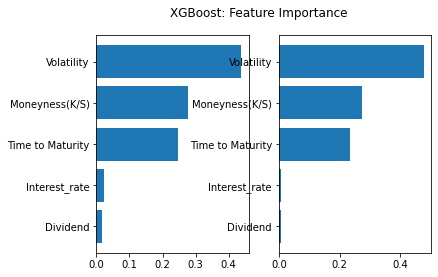

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
xgb_feature_importance1 = pd.Series(tmp_xgb_clf1.feature_importances_ / tmp_xgb_clf1.feature_importances_.sum(), index=['Moneyness(K/S)', 'Time to Maturity', 'Interest_rate', 'Dividend','Volatility']).sort_values()
ax1.barh(xgb_feature_importance1.index, xgb_feature_importance1)
xgb_feature_importance2 = pd.Series(tmp_xgb_clf2.feature_importances_ / tmp_xgb_clf2.feature_importances_.sum(), index=['Moneyness(K/S)', 'Time to Maturity', 'Interest_rate', 'Dividend','Volatility']).sort_values()
ax2.barh(xgb_feature_importance2.index, xgb_feature_importance2)
fig.suptitle("XGBoost: Feature Importance");

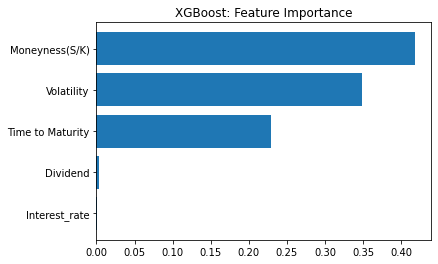

In [ ]:
#xgbr = train_xgb() # always keep the best model
xgb_feature_importance = pd.Series(xgb2.feature_importances_ / xgb2.feature_importances_.sum(), index=['Moneyness(S/K)', 'Time to Maturity', 'Interest_rate', 'Dividend','Volatility']).sort_values()
plt.barh(xgb_feature_importance.index, xgb_feature_importance)
plt.title("XGBoost: Feature Importance");

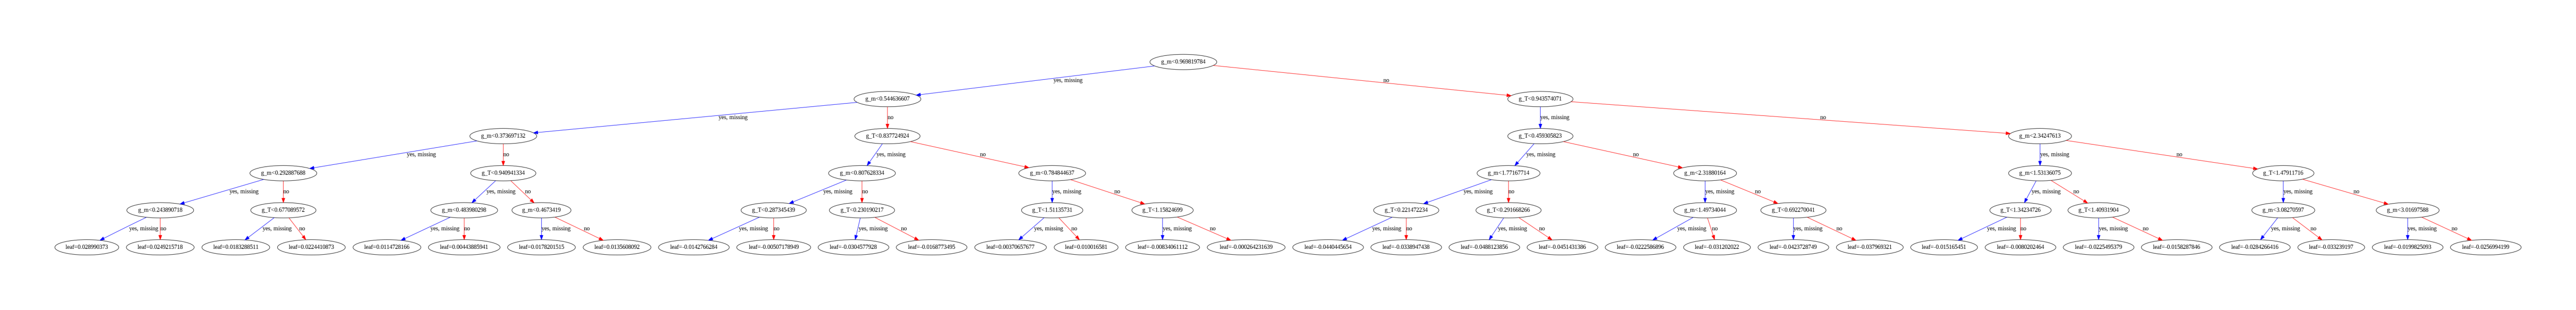

In [ ]:
fig, ax = plt.subplots(1,1, dpi=1000)
xgb.plot_tree(xgb2, ax=ax)
fig;

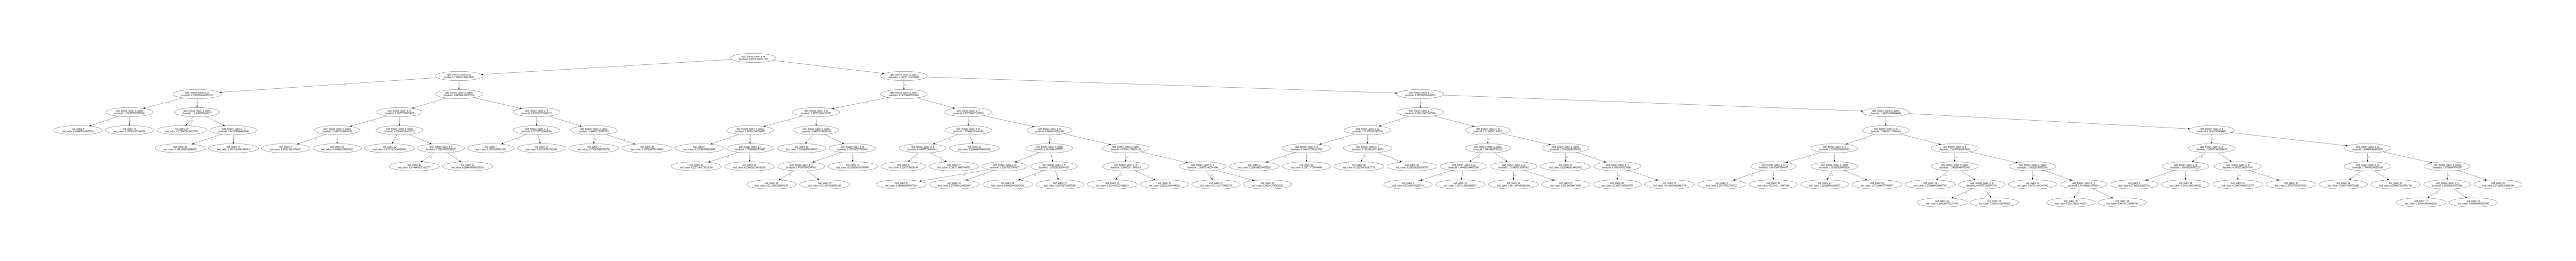

In [ ]:
fig, ax = plt.subplots(1,1, dpi=1000)
lgb.plot_tree(l4, ax=ax)
fig;

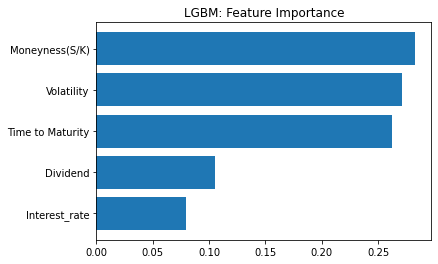

In [ ]:
lgb_feature_importance = pd.Series(l4.feature_importances_ / l4.feature_importances_.sum(), index=['Moneyness(S/K)', 'Time to Maturity', 'Interest_rate', 'Dividend','Volatility']).sort_values()
plt.barh(lgb_feature_importance.index, lgb_feature_importance)
plt.title("LGBM: Feature Importance");